dsas


In [40]:
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk import tokenize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter


In [118]:
data = pd.read_csv('../../Data/cleanedJobs.csv')
print(data.shape)
data.head()



(15000, 12)


,JobRefNo,DigerPozisyon,Qualifications,Classification,Qualifications_HtmlFree,categorical_label,Length,Word_count,mean_word_length,mean_sent_length,Clean,Clean_lists
0,3464108,Bilgisayar Mühendisi,<p>3464105346410534641053464105346410534641053...,Bilgi Teknolojileri,3464105346410534641053464105346410534641053464...,1,126,1,126.000000,126.0,3464105346410534641053464105346410534641053464...,['34641053464105346410534641053464105346410534...
1,3464068,Yazılım Geliştirme Elemanı,<p>sskjdkjsdksajl sksakjdlkajdladl dskjlksjlks...,Bilgi Teknolojileri,sskjdkjsdksajl sksakjdlkajdladl dskjlksjlksajl...,1,111,5,21.400000,111.0,sskjdkjsdksajl sksakjdlkajdladl dskjlksjlksajl...,"['sskjdkjsdksajl', 'sksakjdlkajdladl', 'dskjlk..."
2,3464018,Grafik Tasarımcı,<p>Şartlar</p><p>08.30 - 18.30 arası mesai saa...,Bilgi Teknolojileri,Şartlar 08.30 - 18.30 arası mesai saatleri. Sa...,1,623,81,6.679012,88.0,şartlar 0830 1830 arası mesai saatleri sadece ...,"['şartlar', '08', '30', '-', '18', '30', 'aras..."
3,3463995,Full Stack Developer,<p>Yeditek Yeni Dijital Teknolojiler A.Ş.</p><...,Bilgi Teknolojileri,Yeditek Yeni Dijital Teknolojiler A.Ş. Yeditek...,1,698,90,6.766667,138.8,yeditek yeni dijital teknolojiler aş yeditek e...,"['yeditek', 'yeni', 'dijital', 'teknolojiler',..."
4,3463739,Multimedya Tasarım Uzmanı,<p>Türkiye'de eğitim teknolojileri alanının il...,Bilgi Teknolojileri,Türkiye'de eğitim teknolojileri alanının ilk v...,1,2426,311,6.729904,484.0,türkiyede eğitim teknolojileri alanının ilk ön...,"['türkiye', 'eğitim', 'teknolojileri', 'alanın..."


## Lets Code Google Instructions For Text Classification - N-gram Vectorization

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

### N-gram Vectorization ###
##N-gram vectorization is a common technique for text classification.
##This technique is used to convert text into vectors of numerical values.
def ngram_vectorize(train_texts, train_labels, val_texts, NGRAM_RANGE = (1, 2),TOP_K = 20000
                    ,TOKEN_MODE = 'word',MIN_DOCUMENT_FREQUENCY = 2, vForm = 'tfidf'):
    """
    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams. <br>

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.
        NGRAM_RANGE: The lower and upper boundary of the range of n-values for different n-grams to be extracted.
        TOP_K: The maximum number of features to be selected by SelectKBest.
        TOKEN_MODE: Whether text should be split into word or character n-grams.
        MIN_DOCUMENT_FREQUENCY: Minimum document/corpus frequency below which a token will be discarded.
        vForm: Vectorization form, either 'tfidf' or 'count'

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }

    if vForm == 'tfidf':
        vectorizer = TfidfVectorizer(**kwargs)
    elif vForm == 'count':
        vectorizer = CountVectorizer(**kwargs) 
    else:
        print('Invalid vectorization form')
        return

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val,vectorizer

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import accuracy_score, auc, roc_auc_score
import xgboost as xgb

In [50]:
x_train, x_test, y_train, y_test,  indices_train, indices_test = train_test_split(data['Clean'], 
                                                    data['categorical_label'], 
                                                    data.index,
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify=data['categorical_label'])

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(13499,) (1500,) (13499,) (1500,)


In [51]:
xtrain_tfv,xvalid_tfv,vectorizer = ngram_vectorize(x_train, y_train, x_test, vForm = 'tfidf',  NGRAM_RANGE = (1, 2),
                                        TOP_K = 20000, TOKEN_MODE = 'word',MIN_DOCUMENT_FREQUENCY = 2)

/Users/kemalcankara/miniforge3/envs/nlpEnv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:2060: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [47]:
data.isnull().values.any()

True

In [48]:
data[data['categorical_label'].isnull()]

,JobRefNo,DigerPozisyon,Qualifications,Classification,Qualifications_HtmlFree,categorical_label,Length,Word_count,mean_word_length,mean_sent_length,Clean,Clean_lists


In [49]:
data.drop(5439,axis=0,inplace=True)

In [52]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [13]:
lr_word = LogisticRegression(solver='sag', verbose=1)
lr_word.fit(xtrain_tfv, y_train)
y_pred_word = lr_word.predict(xvalid_tfv)
LR_results=accuracy_score(y_test, y_pred_word)
results = {'LR_TfIDF_unigram': LR_results} 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.13414747
Epoch 3, change: 0.04222032
Epoch 4, change: 0.03149211
Epoch 5, change: 0.02698425
Epoch 6, change: 0.01679677
Epoch 7, change: 0.01177530
Epoch 8, change: 0.00655988
Epoch 9, change: 0.00418503
Epoch 10, change: 0.00141911
Epoch 11, change: 0.00986590
Epoch 12, change: 0.00351831
Epoch 13, change: 0.00062580
Epoch 14, change: 0.00048946
Epoch 15, change: 0.00039389
Epoch 16, change: 0.00030554
Epoch 17, change: 0.00024967
Epoch 18, change: 0.00020037
Epoch 19, change: 0.00016067
Epoch 20, change: 0.00013624
convergence after 21 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


In [14]:
results

{'LR_TfIDF_unigram': 0.9133333333333333}

In [15]:
xtrain_tfv,xvalid_tfv = ngram_vectorize(x_train, y_train, x_test, vForm = 'count',  NGRAM_RANGE = (1, 3),
                                        TOP_K = 20000, TOKEN_MODE = 'word',MIN_DOCUMENT_FREQUENCY = 2)
lr_word.fit(xtrain_tfv, y_train)
y_pred_word = lr_word.predict(xvalid_tfv)
LR_results=accuracy_score(y_test, y_pred_word)
results ['LR_CountV_trigram']= LR_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20788452
Epoch 3, change: 0.11152854
Epoch 4, change: 0.06734075
Epoch 5, change: 0.05131130
Epoch 6, change: 0.04289863
Epoch 7, change: 0.03822422
Epoch 8, change: 0.03353437
Epoch 9, change: 0.02984898
Epoch 10, change: 0.02717892
Epoch 11, change: 0.02543370
Epoch 12, change: 0.02392267
Epoch 13, change: 0.02251929
Epoch 14, change: 0.02124843
Epoch 15, change: 0.02022075
Epoch 16, change: 0.01911430
Epoch 17, change: 0.01833331
Epoch 18, change: 0.01746407
Epoch 19, change: 0.01652230
Epoch 20, change: 0.01580444
Epoch 21, change: 0.01516026
Epoch 22, change: 0.01454262
Epoch 23, change: 0.01402300
Epoch 24, change: 0.01351245
Epoch 25, change: 0.01300218
Epoch 26, change: 0.01254404
Epoch 27, change: 0.01209287
Epoch 28, change: 0.01164736
Epoch 29, change: 0.01128751
Epoch 30, change: 0.01091456
Epoch 31, change: 0.01057665
Epoch 32, change: 0.01026442
Epoch 33, change: 0.00997639
Epoch 34, change: 0.00983950
Epoch 35, change: 0.009

/Users/kemalcankara/miniforge3/envs/nlpEnv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


In [16]:
results

{'LR_TfIDF_unigram': 0.9133333333333333,
 'LR_CountV_trigram': 0.9266666666666666}

In [100]:
xtrain_tfv,xvalid_tfv,vectorizer = ngram_vectorize(x_train, y_train, x_test, vForm = 'tfidf',  NGRAM_RANGE = (1, 1),
                                        TOP_K = 20000, TOKEN_MODE = 'word',MIN_DOCUMENT_FREQUENCY = 2)
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), y_train)
y_pred_word = clf.predict(xvalid_tfv.tocsc())
LR_results=accuracy_score(y_test, y_pred_word)
results ['XGB_TfIdf_uni']= LR_results

 

/Users/kemalcankara/miniforge3/envs/nlpEnv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:2060: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [68]:
results

{'LR_TfIDF_unigram': 0.9133333333333333,
 'LR_CountV_trigram': 0.9266666666666666,
 'XGB_TfIdf_uni': 0.936}

In [69]:
# AUC and accuracy as score
scoring = {'Accuracy':metrics##.make_scorer(accuracy_score)}

# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [f_classif],
    'fs__k': [10],
  }]

model = GridSearchCV(estimator=clf, param_grid=search_space, scoring='accuracy',
                                 verbose=10, n_jobs=-1, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, y_train)  # we can use the full data here but im only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(search_space.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

SyntaxError: '{' was never closed (4098267371.py, line 2)

In [70]:
data['categorical_label'].unique()


array([1, 6, 3, 2, 5, 4, 0])

## Confusion Matrix

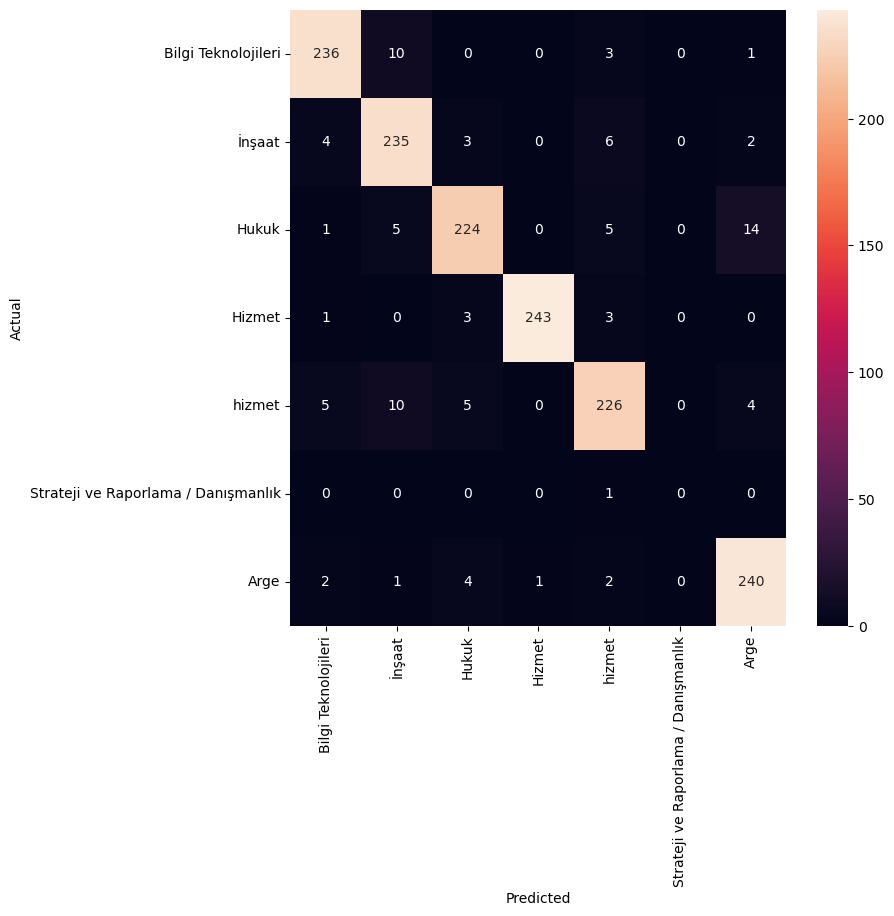

In [71]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_word)
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=data['Classification'].unique(), yticklabels=data['Classification'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## MisClassified Examples

In [72]:
labelsWithName =data.filter(items=['Classification', 'categorical_label']).drop_duplicates()
labelsWithName

,Classification,categorical_label
0,Bilgi Teknolojileri,1
2500,İnşaat,6
5000,Hukuk,3
7500,Hizmet,2
8089,hizmet,5
10000,Strateji ve Raporlama / Danışmanlık,4
12500,Arge,0


In [73]:
conf_mat

array([[236,  10,   0,   0,   3,   0,   1],
       [  4, 235,   3,   0,   6,   0,   2],
       [  1,   5, 224,   0,   5,   0,  14],
       [  1,   0,   3, 243,   3,   0,   0],
       [  5,  10,   5,   0, 226,   0,   4],
       [  0,   0,   0,   0,   1,   0,   0],
       [  2,   1,   4,   1,   2,   0, 240]])

In [74]:
from IPython.display import display
for index, predicted in labelsWithName.iterrows():
  for index, actual in labelsWithName.iterrows(): 
    if predicted['categorical_label'] != actual['categorical_label'] and conf_mat[actual['categorical_label'], predicted['categorical_label']] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(actual['Classification'], predicted['Classification'], conf_mat[actual['categorical_label'], predicted['categorical_label']]))
      display(data.loc[indices_test[(y_test == actual['categorical_label']) & (y_pred_word == predicted['categorical_label'])]][['JobRefNo','Classification', 'Clean']])
      print('')

'Strateji ve Raporlama / Danışmanlık' predicted as 'Bilgi Teknolojileri' : 10 examples.


,JobRefNo,Classification,Clean
12181,3253090,Strateji ve Raporlama / Danışmanlık,holding bünyesinde faaliyetini sürdüren şirket...
12449,3227731,Strateji ve Raporlama / Danışmanlık,genel nitelikler üniversitelerin makine mühend...
10492,3407778,Strateji ve Raporlama / Danışmanlık,kauçuk sektöründe faaliyet gösteren firmamızda...
10335,3424096,Strateji ve Raporlama / Danışmanlık,insan ilişkilerimde başarılıyım hedef kitleler...
12030,3266573,Strateji ve Raporlama / Danışmanlık,qualifications 4 years experiences endtoend bu...
10852,3371415,Strateji ve Raporlama / Danışmanlık,1978 yılında kurulmuş olan şenpiliç iso 500 sa...
11361,3324752,Strateji ve Raporlama / Danışmanlık,belediye projelerimizde görev alacak veri anal...
12289,3242935,Strateji ve Raporlama / Danışmanlık,genel nitelikler iş tanimi tusaştürk havacılık...
11644,3298643,Strateji ve Raporlama / Danışmanlık,qualification bachelors degree computer scienc...
10777,3378873,Strateji ve Raporlama / Danışmanlık,genel nitelikler üniversitelerin ilgili bölüml...



'Arge' predicted as 'Bilgi Teknolojileri' : 10 examples.


,JobRefNo,Classification,Clean
14319,3185543,Arge,qualifications graduated 4year engineering sta...
14699,3132455,Arge,firmamız mevcut arge bünyesine katılmak üzere ...
14381,3177404,Arge,1985 yılında temelleri atılan küçükoğlu holdin...
13943,3240700,Arge,bizimle geleceği tasarla maya hazır mısın tekn...
13354,3327050,Arge,türkiyenin milli gücü türkiyede otomotiv savun...
14778,3119126,Arge,looking business intelligence associate qualif...
13797,3262786,Arge,müşterilerimize led aydınlatma akıllı binaşehi...
12697,3422276,Arge,görev tanımı mevcut ürünler maliyetleri kalite...
13738,3271380,Arge,digiconnect 2022 5 dönem kiş programi 3500den ...
13854,3253319,Arge,sarp lojistik 2004 yılında eskişehir kurulmuşt...



'Hizmet' predicted as 'İnşaat' : 14 examples.


,JobRefNo,Classification,Clean
8736,3433212,Hizmet,üçay grup üçay mühendislik üçay elektromekanik...
8999,3427524,Hizmet,saha mühendisi üniversitelerin inşaat mühendis...
8109,3447968,Hizmet,şirketimizin makine enerji bölümü mekanik bakı...
7686,3460736,Hizmet,inşaat mühendisliği yapı teknik öğretmenliği i...
8241,3445403,Hizmet,elektrik dağıtım sektöründe faaliyet gösteren ...
9808,3408318,Hizmet,temelleri 1986 yılında atılan eksim faaliyet g...
9192,3421958,Hizmet,genel nitelikler üniversitelerin inşaat mühend...
8485,3438704,Hizmet,istanbul merkezli firmamızın kocaelikaramürsel...
9249,3420728,Hizmet,iş tanimi erkut inşaat istanbul şubesi hizmet ...
8160,3446802,Hizmet,genel nitelikler üniversitelerin inşaat mühend...


## Most Correlated Terms With Classes

In [117]:

# Get Most Correlated Terms With each Classes HOMEWORK



 




## Classification Report

In [104]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_word, target_names=data['Classification'].unique()))

                                     precision    recall  f1-score   support

                Bilgi Teknolojileri       0.95      0.94      0.95       250
                             İnşaat       0.90      0.94      0.92       250
                              Hukuk       0.94      0.90      0.92       249
                             Hizmet       1.00      0.97      0.98       250
                             hizmet       0.92      0.90      0.91       250
Strateji ve Raporlama / Danışmanlık       0.00      0.00      0.00         1
                               Arge       0.92      0.96      0.94       250

                           accuracy                           0.94      1500
                          macro avg       0.80      0.80      0.80      1500
                       weighted avg       0.94      0.94      0.94      1500



/Users/kemalcankara/miniforge3/envs/nlpEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kemalcankara/miniforge3/envs/nlpEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kemalcankara/miniforge3/envs/nlpEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## What can we say about bag-of-word models before we move on?

<b>Pros:<b> They can be surprisingly powerful given their simplicity, they are fast to train, and easy to understand and interpret.<br><br>
<b>Cons:<b> Even though ngrams bring some context between words, bag of word models fail in modeling long-term dependencies between words in a sequence. They increase the dimensionality of the problem